In [ ]:
pip install plotly

Python interpreter will be restarted.
Requirement already satisfied: plotly in /databricks/python3/lib/python3.8/site-packages (5.3.1)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from plotly) (1.15.0)
Requirement already satisfied: tenacity>=6.2.0 in /databricks/python3/lib/python3.8/site-packages (from plotly) (8.0.1)
Python interpreter will be restarted.

#START

Importing NLTK

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data] Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Package omw-1.4 is already up-to-date!
Out[1]: True

## Get Data

Importing data from snowflake

In [ ]:
# snowflake connection options
options = {
"sfUrl": ".snowflakecomputing.com",
"sfUser": "",
"sfPassword": "",
"sfDatabase": "",
"sfSchema": "",
"sfWarehouse": ""
}

In [ ]:
# Build Query
sql_query = f"""
SELECT
TOP 150 *  from "VW_GAME_DESCRIPTION_MASTER" WHERE GAMETITLE is not NULL
"""
# Generate a simple dataset
df = spark.read \
.format("snowflake") \
.options(**options) \
.option("query", sql_query ) \
.load()

df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 TITLE| GAMEDESCRIPTION| GAMEINSTRUCTIONS| GAMETITLE| SEODESCRIPTION| SEOKEYWORDS| SEOTITLE|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 40_joker_staxx|<p>Are you a fan ...|<p>This classic s...|CLASSIC ONLINE SL...|Recall the experi...|casino slots, cla...|Classic Free Onli...|
 7diamond_c6a|<p>One of the mos...|<p>7 DIAMOND is a...|7 Diamond - FREE ...|Relive the experi...|7 Diamond, crista...|7 Diamond - Crist...|
 9_happy_pharaohs|<p>The team of an...|<p>In this slot y...|Slot Machine Casi...|Meet a never-befo...| null|9 Happy Pharaohs ...|
 alkemors_tower|<p>You don't need...|<p>Dust off your ...|Video Slot Magic ...|There is plenty o...|video slot, slot ...|Alkemor's Towers ...|
 anubis|<p>If you like th...|<p>In this free s...|ANUBIS: PLAY ONLI...|Play free online ...|free online slot ...|Free online slot ...|
 art_of_the_heist|<p>Help Vincenzo ...|<p>In this slot m...|SLOT MACHINE WITH...|Learn from the be...|slots casino, Art...|Art of the Heist ...|
 blackjack|<p>Blackjack is a...|<p>When the game ...|21 European Black...|Who hasn’t played...|poker, blackjack,...|Blackjack Online ...|
 blackjack_us|<p>Blackjack is a...|<p>When the game ...|21 European Black...|Who hasn’t played...| null|Blackjack Online ...|
 blazeofra|<p>The powerful G...|<p>In this video ...|EGYPTIAN VIDEO SL...|Use the Sun God's...| null|Blaze of Ra - Egy...|
 blood_eternal|<p>If you like sl...|<p>This video slo...|Vampire Video Slo...|Spin the 6 reels ...| null|Blood Eternal - V...|
 book_of_gold|<p>The mysterious...|<p>In this slot m...|Free 5-reel Slot ...|Enjoy playing Boo...|slots casino, Boo...|Free 5-reel Slot ...|
 book_of_gold_choice|<p>Ancient Egypt ...|<p>In this slot m...|Egyptian Slot - B...|Enjoy playing the...| null|Ancient Egyptian ...|
book_of_gold_mult...|<p>Take a trip to...|<p>Book Of Gold: ...|Book Of Gold: Mul...|Travel to ancient...|book of gold, mul...|Book Of Gold: Mul...|
 buffalo_power|<p>Relive the wil...|<p>In this online...|Buffalo Power - W...|Have you ever wan...| null|Buffalo Power - W...|
 bumper_crop|<p>Do you like th...|<p>This slot cons...|FARM SLOT MACHINE...|Become a powerful...| null|Bumper Crop - Far...|
 burlesque_queen|<p>Do you know th...|<p>In this slot m...|Free Casino Slot ...|The Moulin Rouge ...|casino slots, cas...|Casino Slots Onli...|
 burning_wins|<p>Do you love cl...|<p>This classic s...|CLASSIC SLOT MACH...|Relive the experi...|casino slots, cla...|Burning Wins - Cl...|
 carnaval_forever|<p>Did you know t...|<p>Carnaval Forev...|Carnaval Rio de J...|Join the Brazilia...|carnival forever,...|Carnaval Forever ...|
 chicago_gangsters|<p>Chicago Gangst...|<p>In this video ...|VideoSlots Free O...|Travel back in ti...|video slots, vide...|VideoSlots Free O...|
 christmas_eve|<p>Yo-ho-ho! Chri...|<p>This Christmas...|Christmas VIDEO S...|Christmas Eve is ...|casino slots, vid...|Christmas Eve - C...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 20 rows

## Import Libraries

Importing Libraries

In [ ]:
from gensim.models import Word2Vec
import pandas as pd 
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.parsing.preprocessing import remove_stopwords
from textblob import TextBlob, Word
from gensim.utils import tokenize
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
import numpy as np
from wordcloud import WordCloud
import seaborn as sn
from gensim.test.utils import common_texts

from sklearn.metrics import silhouette_score

In [ ]:
Dataset = df.toPandas()

In [ ]:
Dataset['Combine'] = Dataset["GAMEDESCRIPTION"]+Dataset['GAMEINSTRUCTIONS']

## Preprocessing

Preprocessing includes:
  - Remove HTML Tags
  - Lower Case letter
  - Remove stop words / gensim and personal
  - lemmanize
  
We execute the combination of GAMEDESCRIPTION + GAMEINSTRUCTION to have bigger dataset

In [ ]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    ret  = re.sub(clean, '', text)
    return ret

In [ ]:
def lower(text):
  return text.lower()

In [ ]:
def removeStopWords(text):
  return  [word for word in text if not word in stopwords.words()]

In [ ]:
def lemmanize(text):
  sent = TextBlob(text)
  return " ". join([w.lemmatize() for w in sent.words])

In [ ]:
def tok(text):
  return list(tokenize(text))
 

In [ ]:
def removeSpecialWords(text):

  mystopwords = ['ll', 'nbsp','slot','game','prize','scatter','classig','play','casino','betting'
                 ,'win','winning','symbol','scatter','bonus','bonuses','winning','figures','3x5','table','machine','screen','blackjack','poker','multiplier'
                ,'spin','bet','prize','bar','love','grid','combination','classic','paid','line','set','pay','figure',                              'button','free','level','player','reel','five','gift','mode','freespins','spins','seven','blue','green','red','triple',
                'appear','rich','place','online','reward','lines', 'symbol','betting','joker',' staxx','prizes','prize','jokers','incredible','wild', 'vertically' ,'horizontally','position','random','board','fun','enjoy','happy','engergise','energy']#,'slot','machine','game', 'play' , 'get', 'waiting', 'try']
 
  for word in list(text):  # iterating on a copy since removing will mess things up
      if word in mystopwords:
          text.remove(word)

  return text

In [ ]:
#Not using it yet
new_stopwords = [x for x in stopwords.words() if x != 'you']

In [ ]:
"""
Preprocessing function passing the whole description
"""
def Preprocessing(Description):
  CleanDesc = remove_html_tags(Description)
  CleanDesc = lower(CleanDesc)
  CleanDesc = tok(CleanDesc)
  filtered_sentence = removeStopWords(CleanDesc)
  
  lemmatized_out = lemmanize(' '.join(filtered_sentence))
  #lem =tok(filtered_sentence)

  lem =  removeSpecialWords(lemmatized_out.split())
  return lem 
#lem = Preprocessing(Dataset['Combine'][0])


In [ ]:
""" 
Executing preprocessing for each description in 'Combine'
"""
words_text = []
for i in range(0,150):
  words_text.append(Preprocessing(Dataset['Combine'][i]))



## Word2Vec Model

Applying Word2vec model.
With small epochs it give us a PCA static of 100% just with one components. This generates underfitting in the model. To have a proper model we have to atleast use 100 epochs

In [ ]:
model = Word2Vec(sentences=words_text, size=100, window=5, min_count=1, workers=4)

Each word is a vector

In [ ]:
model.train(words_text, total_examples=1, epochs=100)

Out[17]: (1354287, 1491000)

In [ ]:
""" 
Creating the dataframe with the data of the model. 

"""
my_dict = dict({})
for idx, key in enumerate(model.wv.vocab):
    my_dict[key] = model.wv[key]
    # Or my_dict[key] = model.wv.get_vector(key)
    # Or my_dict[key] = model.wv.word_vec(key, use_norm=False)

wordsvectors = pd.DataFrame.from_dict(my_dict).T

In [ ]:
type(wordsvectors)

Out[19]: pandas.core.frame.DataFrame

In [ ]:
wordsvectors

Out[20]:

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
fan,-0.008920,-0.316835,-0.159333,0.313214,-0.409622,-0.096609,0.040675,-0.924039,-0.022954,0.064504,0.727909,-0.317294,0.435159,-0.226699,0.284565,-0.200479,0.696419,0.296905,-0.425232,1.054523,0.373442,0.257567,-0.295507,0.745292,-0.272964,-1.303029,0.257547,0.096624,0.374000,0.030721,-0.126996,0.378982,-0.283554,-0.343598,-0.631654,-0.121115,-0.038637,-0.618043,-0.026587,-0.134455,...,-0.188187,-0.023460,-0.343284,-0.166927,0.439569,-0.171551,1.157216,0.822773,-0.378156,-0.325280,0.303889,0.096475,0.714631,-0.096297,-0.695029,0.035376,-0.352626,-0.107744,-0.138649,0.402182,0.558537,0.129538,-0.131439,0.347871,-0.562354,-0.082332,0.321668,-0.124662,-0.344858,-0.121562,-0.674859,-0.039300,0.084362,0.786476,-0.330360,0.595590,0.745213,0.253780,-0.162476,-0.232856
staxx,0.291364,-0.316393,-0.109393,0.579843,-0.309617,0.048926,-0.391718,-0.717789,-0.267693,0.215015,0.867498,-0.593313,0.518145,-0.245744,-0.128074,-0.256479,1.198511,0.587853,-0.197139,0.943347,0.207779,0.261443,-0.133608,0.924238,-0.248951,-1.598572,0.269733,0.137583,0.541205,0.161341,0.257495,0.622856,-0.294028,-0.370108,-1.039858,-0.292211,-0.126236,-1.099650,-0.436030,-0.071520,...,-0.064431,0.144715,-0.719601,-0.082012,0.492548,0.058904,1.346103,0.919177,-0.437964,-0.029396,0.039702,0.081161,0.562802,0.400730,-0.630639,0.125290,-0.376770,-0.477186,-0.054808,0.902773,0.762450,-0.203460,-0.089632,0.245879,-0.395146,0.125610,0.092003,0.128540,-0.635545,-0.315745,-0.862667,-0.339478,0.208312,1.051995,-0.446821,1.150130,1.184785,0.200109,-0.276809,-0.566185
elegant,-0.330626,-1.018752,0.276095,0.980595,-1.928253,-0.352206,0.670119,-1.069583,-0.251056,-0.222767,1.910074,-0.890637,0.022200,0.182588,1.093823,-1.614384,1.988186,0.646286,-0.635546,0.914218,-0.374054,1.735266,-1.080378,1.413864,-0.944546,-2.086185,-0.146445,-0.408344,-0.627574,0.557572,-0.110551,-0.636627,0.572864,-0.618664,-0.964222,-0.453376,0.042229,-1.090198,-0.769310,-0.447639,...,-0.099519,-0.570943,-0.962278,-1.436425,0.990080,-0.308023,1.872181,1.455701,-0.247708,-0.896494,0.903471,0.164492,1.691078,-0.641063,-1.364126,0.045231,-0.513305,-0.414060,-0.135718,0.713968,1.553845,-1.354766,-0.779622,0.907071,-1.842935,-0.237591,0.848281,0.070306,-0.603029,-0.534785,-1.905365,-0.536763,0.091575,1.894709,-1.053348,0.554514,1.289737,1.450868,0.117356,-0.469816
x,-1.342161,1.473771,1.814637,0.135755,-1.517375,-0.389326,0.721671,1.086607,0.508503,0.019437,2.441821,-0.469953,-0.803256,1.161879,1.279134,-1.954306,1.546454,0.416704,0.013856,0.249365,0.410958,-0.113426,-2.042848,0.494483,-0.883218,-2.043727,-0.829678,0.964804,0.879062,0.435206,0.422316,-0.798343,0.445907,-1.200880,-0.672641,-1.155264,0.971099,-1.514545,-1.393227,-1.374140,...,1.333987,0.623340,-1.034843,-2.588749,1.395460,0.801562,2.045765,-0.519730,0.477676,-0.752731,0.407778,-0.446713,1.758491,0.972498,0.675655,0.062123,0.685442,-0.123794,1.341941,0.616118,2.389956,-1.384175,-1.028404,1.981921,-0.447513,-0.326804,-1.362020,1.025087,-1.446390,-0.659678,-1.238602,-1.081223,-0.836657,1.250587,-0.975119,2.139099,0.996671,1.442148,0.531726,-1.655567
put,0.327570,-0.679984,0.393090,-0.211002,-1.328740,-0.374080,-0.361465,0.830384,-0.724723,0.266373,1.065577,-0.643569,-0.023151,-0.230736,0.801983,-1.096872,0.958428,-0.249500,-0.775675,0.397067,-0.885350,1.117498,-0.605642,0.340935,-0.949149,-1.046246,-0.202968,0.010642,0.083518,-0.053252,-0.417557,0.333515,0.030958,-0.307929,-0.613827,0.665092,-0.755012,-1.029741,-0.844090,0.673091,...,0.412375,-0.440992,-0.557541,-0.533171,1.537217,0.813360,1.548325,0.578319,0.213599,-0.285675,0.835786,0.195985,1.036579,-1.176252,-1.232960,0.469508,-0.343053,-0.753800,-0.415229,0.772945,0.834193,-0.814659,-0.642349,-0.395519,-1.361763,-0.438594,1.102266,0.214817,-0.235458,-0.580774,-

## MDS Words Representation

In [ ]:
from sklearn.manifold import MDS
"""
Visualizing the distance between words  to see what words are the most different from each other 
"""

### Step 1 - Configure MDS function, note we use default hyperparameter values for this example
model2d=MDS(n_components=2, 
          metric=True, 
          n_init=4, 
          max_iter=300, 
          verbose=0, 
          eps=0.001, 
          n_jobs=None, 
          random_state=42, 
          dissimilarity='euclidean')

### Step 2 - Fit the data and transform it, so we have 2 dimensions instead of 3
X_trans = model2d.fit_transform(wordsvectors)
    
### Step 3 - Print a few stats
print('The new shape of X: ',X_trans.shape)
print('No. of Iterations: ', model2d.n_iter_)
print('Stress: ', model2d.stress_)

The new shape of X: (2687, 2)
No. of Iterations: 300
Stress: 4317380.385158776

In [ ]:
X_trans

Out[22]: array([[ 3.8035597 , 0.42407347],
 [ 4.87372646, 0.98160559],
 [ 7.32246952, 6.73776832],
 ...,
 [-0.87421542, -0.21371902],
 [-0.78592807, -0.17038356],
 [-0.86698387, -0.19839956]])

In [ ]:
import plotly.express as px # for data visualization
# Create a scatter plot
fig = px.scatter( x=X_trans[:,0], y=X_trans[:,1], opacity=1, color =wordsvectors.index.values)

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Set figure title
fig.update_layout(title_text="MDS Transformation")

# Update marker size
fig.update_traces(marker=dict(size=5,
                             line=dict(color='black', width=0.2)))

fig.show()

Distance close words

Magic - Joker / 
Video-Number-Wild / 
Night - Epic - gangster / 
Asian - Kingdom / 
Alkemor - World /
Dragon - Pharao /
European - Cabaret -Sun /

## Creating Dataframe vectors for document

We want to create a dictionary with:
  - Number of times a word appears ( Same cluster )
  - Number of documents (Same cluster) a word appears in

In [ ]:
check = []
dict_vec = {}
for i in range(0,150):
  for j in words_text[i][:]:
      #print("esto es {}".format(i) , j)
      check.append(model[j])
      dict_vec[i] = check
      
  check = []

<command-4282437243061636>:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

In [ ]:
out_arr =0 
array_Sum = []
array_Total = []
k=0
for k in dict_vec.values():
  out_vec = np.sum(np.array(k),axis=0)
  array_Total.append(out_vec)
 


In [ ]:
np.array(array_Total).shape

Out[26]: (150, 100)

In [ ]:

df = pd.DataFrame(np.array(array_Total))
df.shape
df.head()

Out[28]:

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-11.742001,-41.397964,-2.672111,33.770031,-54.582035,29.341759,-11.393665,-7.173357,-34.058517,16.300156,27.177250,-20.178705,-2.132079,-10.871181,21.957115,-18.380125,43.848034,17.241831,-21.529360,47.435131,-41.785301,43.522739,2.868771,7.306346,-34.974339,-71.650917,-16.602333,3.734406,-7.998104,37.070881,17.711391,22.872927,1.723729,-9.717451,-34.331619,-3.502907,-33.604729,-37.784973,-48.251335,-17.554745,...,21.079618,3.006523,-30.293381,-47.275974,62.911190,38.194523,52.912975,10.740333,-11.390541,5.469567,0.639225,10.368982,5.631372,-3.841604,-23.080433,42.752884,-22.293177,-5.347333,26.101759,57.873283,53.109505,-25.770882,-56.442112,-14.609804,-38.910885,9.905223,21.537357,32.400047,-3.789282,-26.582434,-53.490833,-22.916351,-1.941161,54.590576,-33.538273,65.013458,55.440647,11.921400,-4.864650,-15.217186
1,-0.780863,-56.822800,-13.957293,63.031487,-39.305588,43.300808,37.727551,-10.619027,-36.214691,-1.058681,-13.607487,-41.975727,17.740015,-37.449860,-37.770611,-7.474781,27.346592,0.578145,-13.582753,1.332033,-69.167870,34.987499,53.545486,-12.703905,11.432208,-9.820584,-22.012016,-52.032185,-6.593973,53.532051,48.973824,-24.917400,-22.919727,14.419699,-37.151142,-52.860249,19.358276,5.059570,-51.413406,-40.030422,...,-35.458225,22.073641,-22.372696,-57.058533,6.313098,21.830750,-6.843657,13.019799,-26.801199,19.500656,-18.586809,33.602100,-0.735180,-32.847179,17.638781,23.111242,-16.772270,6.127310,63.633011,53.754738,22.404797,-36.582672,-86.747810,-50.632206,-5.148101,4.006563,27.575773,13.432686,-8.073365,-35.306389,-40.913204,-41.701729,-31.307642,26.344057,25.549879,-1.044793,34.261162,22.798414,-7.042101,-5.533449
2,-28.440390,-26.940865,-2.793173,14.718261,-37.718575,1.512025,-1.210239,-30.810453,-16.637638,1.274757,10.257222,0.496705,-13.350743,-8.409691,13.387472,-2.562716,31.036913,18.569942,2.364784,41.955082,-30.355827,3.973662,13.470800,9.731349,-14.928177,-35.591133,12.922443,-1.868548,-9.569445,42.641094,29.124115,19.093895,-3.949105,-12.304576,-23.549438,-3.433469,-30.512110,-21.481720,-33.400108,-23.320829,...,30.421913,-11.896149,-2.449760,-41.555157,19.707281,29.058771,19.729439,-17.215277,-21.353474,0.947285,-12.979909,13.396137,2.711177,-3.106552,3.486157,36.550297,-15.410481,-5.040593,31.675861,47.935665,28.885437,-13.177684,-41.900200,-0.635444,-12.650498,15.669116,8.895502,37.287342,-12.079685,-21.794542,-23.677170,-15.910076,-8.789845,54.486851,4.273354,44.882721,25.885399,5.526940,8.274588,-9.335361
3,-2.973161,-107.761055,-58.111286,118.276810,-105.045464,24.440044,61.061623,-174.743393,4.341846,6.781562,-41.218666,-7.395563,-3.733835,-141.507278,5.454390,64.811783,94.184128,146.374512,-4.288921,67.882263,-27.855875,80.495750,60.459335,13.232322,-103.760406,43.599300,17.504889,11.456573,31.277184,23.680792,-3.113763,8.669827,35.149509,113.823395,-72.455238,-34.648327,-28.857088,37.969254,27.990467,-91.902504,...,29.725510,-102.628723,69.665741,-20.117825,78.816650,-19.296751,59.522999,-13.569545,-55.534748,31.812170,98.943336,-98.032928,-38.675941,-7.979787,-144.755753,35.519424,-102.568367,-93.358002,160.157074,94.564308,71.625175,-53.870171,-119.294319,-63.163620,-80.441933,-21.403713,97.088463,-10.207829,-44.289097,-158.887222,-154.181747,15.774995,-19.599253,62.980045,103.998215,9.119149,92.726746,-25.558897,-30.446840,-53.595524
4,-22.696201,-33.896271,10.650796,23.006113,-37.421993,23.877012,31.201111,-52.314304,-11.372912,43.846832,-34.643604,-19.360369,24.148684,-62.914162,-6.424029,9.492822,47.023567,52.719547,2.352722,30.658497,-32.075657,22.199675,11.204039,-13.255109,-36.364311,4.755782,8.203504,5.161200,-15.022088,28.378580,15.418073,-18.700886,9.948661,38.323914,-29.206659,11.839748,-14.197503,13.387837,-34.564133,-17.676582,...,-5.962655,-2

### Normalize

In [ ]:
normalized_df=(df-df.min())/(df.max()-df.min())

In [ ]:
normalized_df.head()

Out[30]:

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.790828,0.485703,0.460691,0.291117,0.722265,0.740177,0.280013,0.626377,0.535474,0.818360,0.903126,0.498716,0.604951,0.720444,0.932822,0.186682,0.150511,0.446777,0.056008,0.765787,0.656473,0.790739,0.181265,0.280832,0.503172,0.262131,0.646749,0.522310,0.236319,0.211495,0.193935,0.533426,0.619549,0.116594,0.855141,0.389427,0.251170,0.255945,0.352347,0.507427,...,0.562420,0.737778,0.385989,0.364746,0.858340,0.532027,0.601243,0.577367,0.840374,0.338134,0.553476,0.706242,0.522656,0.518870,0.584712,0.477773,0.416705,0.804822,0.133367,0.360332,0.286186,0.783056,0.802863,0.845012,0.338133,0.316199,0.441328,0.560217,0.956827,0.815659,0.684444,0.432726,0.390025,0.201939,0.069297,0.450331,0.573309,0.526799,0.398789,0.669523
1,0.842037,0.386498,0.366913,0.446987,0.821036,0.801468,0.690086,0.613497,0.517832,0.752588,0.667352,0.325477,0.718304,0.573866,0.473817,0.293297,0.100705,0.375387,0.098999,0.566000,0.552193,0.764386,0.386210,0.214493,0.842638,0.653320,0.621795,0.130541,0.240273,0.297560,0.324820,0.178761,0.374871,0.226308,0.846416,0.176289,0.586984,0.629259,0.336402,0.358732,...,0.134168,0.851138,0.432424,0.327099,0.546524,0.432543,0.247354,0.592560,0.772942,0.438734,0.466147,0.857607,0.472982,0.397762,0.780389,0.384898,0.445364,0.868730,0.334673,0.337499,0.141129,0.690377,0.644398,0.727509,0.499445,0.299626,0.485979,0.438532,0.939885,0.769920,0.759295,0.285124,0.221790,0.065246,0.469144,0.032458,0.507468,0.634276,0.378689,0.740799
2,0.712815,0.578685,0.459685,0.189632,0.831297,0.617983,0.365026,0.538022,0.678018,0.761430,0.805312,0.663041,0.540957,0.734019,0.866965,0.341320,0.111843,0.452467,0.185275,0.742039,0.700000,0.668629,0.224141,0.288871,0.649811,0.490274,0.782942,0.482948,0.231894,0.240618,0.241716,0.505381,0.563225,0.104834,0.888507,0.389727,0.270779,0.397999,0.427235,0.469280,...,0.633184,0.649176,0.549221,0.386762,0.620317,0.476486,0.404724,0.391042,0.796780,0.305709,0.491615,0.725964,0.499872,0.521939,0.712378,0.448444,0.452433,0.806531,0.163265,0.305239,0.171746,0.891006,0.878900,0.890595,0.463600,0.332392,0.347846,0.591572,0.924041,0.840762,0.861869,0.487777,0.350790,0.201437,0.325166,0.322987,0.481430,0.463614,0.520073,0.712816
3,0.831795,0.058887,0.000000,0.741267,0.395990,0.718655,0.884884,0.000000,0.849679,0.782295,0.507734,0.600315,0.595814,0.000000,0.805999,1.000000,0.302440,1.000000,0.149278,0.854395,0.709520,0.904895,0.414171,0.300478,0.000000,0.991297,0.804080,0.576560,0.346924,0.141486,0.106747,0.428021,0.951425,0.678143,0.737166,0.254933,0.281273,0.916008,0.736800,0.015557,...,0.627909,0.109740,0.971993,0.469262,0.945968,0.182508,0.640388,0.415341,0.647214,0.527006,1.000000,0.000000,0.176957,0.501592,0.000000,0.443570,0.000000,0.314652,0.852398,0.563743,0.373659,0.542188,0.474217,0.686632,0.139706,0.228235,1.000000,0.286866,0.796667,0.121994,0.085220,0.736735,0.288865,0.242538,1.000000,0.096753,0.689222,0.156452,0.162647,0.387045
4,0.739651,0.533951,0.571402,0.233780,0.833215,0.716183,0.635602,0.457640,0.721096,0.922733,0.545744,0.505220,0.754860,0.433433,0.714714,0.459180,0.160095,0.598769,0.185209,0.693086,0.693450,0.724903,0.214974,0.212665,0.493005,0.745541,0.761175,0.532334,0.216538,0.166048,0.184334,0.224895,0.701212,0.334964,0.871000,0.455680,0.374223,0.701825,0.421365,0.506621,...,0.357585,0.582378,0.739387,0.402179,0.661362,0.470137,0.292594,0.207913,0.766090,0.274556,0.598546,0.657337,0.261924,0.418189,0.504726,0.227477,0.404467,0.671796,0.305809,0.121231,0.120507,0.916386,0.729442,0.869141,0.401357,0.222992,0.497040,0.522981,0.919078,0.792918,0.745991,0.680380,0.288119,0.172470,0.410147,0.330640,0.570496,0.561196,0.277805,1.000000


## Kmeans Model

In [ ]:
n =2
#Initialize the class object
kmeans = KMeans(n_clusters= n)
kk = kmeans.fit(df)
print('KMeans tSNE Scaled Silhouette Score: {}'.format(silhouette_score(normalized_df, kk.labels_, metric='euclidean')))


KMeans tSNE Scaled Silhouette Score: 0.302408903837204

In [ ]:
def CountingForClass(value, arra):
  print('this is arra 4 '  ,arra[4])
  alldata2 = []
  for i in range(0,150):
    if arra[i] == value:
      arr = Preprocessing(Dataset['Combine'][i])
      alldata2.append(' '.join(arr))
  x = word_count(' '.join(alldata2))
  return dict(sorted(x.items(), key=lambda item: item[1],reverse = True)[:])

In [ ]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

[0.25513372 0.21251687 0.11952999 0.08363007 0.0652529 0.04149786]

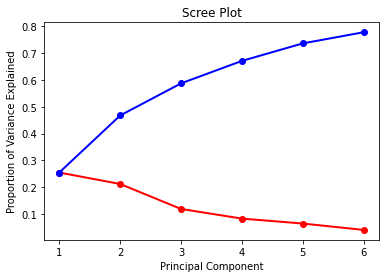

In [ ]:
pca = PCA(n_components =6)
pca.fit(normalized_df)
PCA_components = pd.DataFrame(pca.fit_transform(df))
print(pca.explained_variance_ratio_)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'bo-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.xticks(PC_values)
plt.ylabel('Proportion of Variance Explained')
plt.show()


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb168044a60>
Traceback (most recent call last):
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
 self._make_module_from_path(filepath)
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
 module = module_class(filepath, prefix, user_api, internal_api)
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
 self.version = self.get_version()
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
 config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb168044a60>
Traceback (most recent call last):
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
 self._make_module_from_path(filepath)
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
 module = module_class(filepath, prefix, user_api, internal_api)
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
 self.version = self.get_version()
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
 config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb168044a60>
Traceback (most recent call last):
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
 self._make_module_from_path(filepath)
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
 module = module_class(filepath, prefix, user_api, internal_api)
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
 self.version = self.get_version()
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
 config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb168044a60>
Traceback (most recent call last):
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
 self._make_module_from_path(filepath)
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
 module = module_class(filepath, prefix, user_api, internal_api)
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
 self.version = self.get_version()
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
 config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb168044a60>
Traceback (most recent call last):
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
 self._make_module_from_path(filepath)
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
 module = module_class(filepath, prefix, user_api, internal_api)
 File "/databricks/python/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
 self.version = self.ge

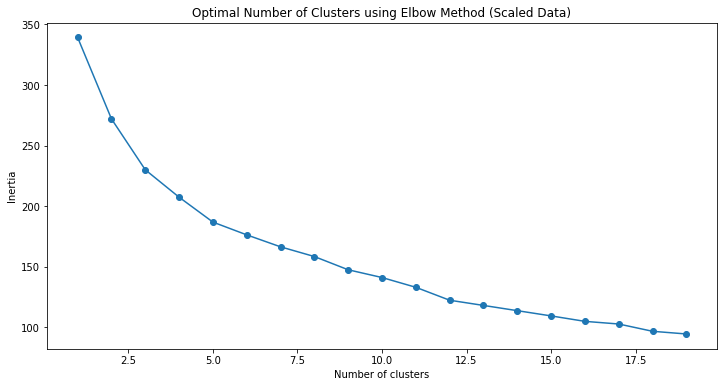

Text(0, 0.5, 'Inertia')

In [ ]:
"""
Using normalised dataframe
"""
sse = []
k_list = range(1, 20)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(normalized_df)
    sse.append([k, km.inertia_])
    
oca_results_scale = pd.DataFrame({'Cluster': range(1,20), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
"""KMeans based on PCA_components"""
n =5
#Initialize the class object
kmeans = KMeans(n_clusters= n)
kk = kmeans.fit(normalized_df)
print('KMeans tSNE Scaled Silhouette Score: {}'.format(silhouette_score(normalized_df, kk.labels_, metric='euclidean')))

#predict the labels of clusters.
label2=  kmeans.fit_predict(normalized_df)

KMeans tSNE Scaled Silhouette Score: 0.17709429562091827

In [ ]:
print("For each document what class are they into : \n", label2)

count_arr = np.bincount(label2)
print(count_arr[0])
print(count_arr[1])
print(count_arr[2])


For each document what class are they into : 
 [1 0 1 2 0 1 4 4 1 0 1 2 2 1 0 1 0 0 1 0 1 0 4 1 1 4 4 0 0 0 0 1 1 1 0 0 0
 1 1 4 4 1 0 0 1 4 0 0 0 0 1 1 1 0 0 2 0 4 4 0 0 0 0 2 0 1 1 1 1 0 1 0 4 4
 4 4 4 4 3 4 1 1 2 4 0 0 1 1 0 4 0 4 0 0 0 0 0 0 0 1 1 0 4 1 0 4 1 0 0 1 0
 1 0 1 1 0 4 0 0 0 2 0 0 0 0 0 2 2 0 1 0 4 0 1 1 1 2 0 0 0 1 1 2 0 0 1 0 0
 0 0]
69
45
11

In [ ]:
len(np.array(np.where(label2 == 0))[0])


Out[38]: 69

## Recount words for cluster

In [ ]:
save = []
for i in range(0,4):
    #print("for the class {} :".format(i) ,CountingForClass(i,label2), "\n")
     save.append(CountingForClass(i,label2))

this is arra 4 0
this is arra 4 0
this is arra 4 0
this is arra 4 0

In [ ]:
len(save[1])

Out[40]: 1137

### Recude Text Size

In [ ]:
def reduceTextSize(n_cluster):
  ff_word = []
  #leng = []
  for i in range(0,len(np.array(np.where(label2 == n_cluster))[0])):
    #print(words_text[np.array(np.where(label2 == 0))[0][i]])
    #print("ANTES " , len(words_text[np.array(np.where(label2 == 0))[0][i]]))
    final_words_text = list(dict.fromkeys(words_text[np.array(np.where(label2 == n_cluster))[0][i]]))
    #leng.append(len(final_words_text))
    ff_word.append(final_words_text)
    
  print()
  return ff_word
  #,leng


In [ ]:
reduceTextSize(0)

#type(np.concatenate(reduceTextSize(0)))

Out[42]: [['famous',
 'italy',
 'already',
 'arrived',
 'diamond',
 'cristaltec',
 'besides',
 'waiting',
 'try',
 'vlot',
 'faithful',
 'representation',
 'physical',
 'counterpart',
 'base',
 'real',
 'veteran',
 'able',
 'remember',
 'video',
 'within',
 'special',
 'stopped',
 'enter',
 'number',
 'defines',
 'three',
 'select',
 'tip',
 'star',
 'get',
 'extra',
 'probability',
 'process',
 'added',
 'increasing',
 'highest',
 'order',
 'double',
 'following',
 'give',
 'rise',
 'bell',
 'cherry',
 'least',
 'rewarding',
 'favorite'],
 ['like',
 'mystery',
 'ancient',
 'egypt',
 'playing',
 'wait',
 'longer',
 'find',
 'amazing',
 'surprise',
 'anubis',
 'would',
 'able',
 'get',
 'golden',
 'trophy',
 'waiting',
 'giving',
 'best',
 'tomb',
 'temple',
 'nile',
 'three',
 'orb',
 'dare',
 'defy',
 'jackal',
 'headed',
 'god',
 'test',
 'right',
 'left',
 'begin',
 'become',
 'appears',
 'expand',
 'awarded',
 'regardless',
 'additional',
 'mute',
 'silence',
 'show',
 'help',
 'page',
 'cleopatra',
 'adversity',
 'egyptian',
 'pharaoh',
 'mythology',
 'legend'],
 ['like',
 'story',
 'creature',
 'night',
 'blood',
 'eternal',
 'epic',
 'bloody',
 'vampire',
 'first',
 'bite',
 'video',
 'feature',
 'system',
 'three',
 'row',
 'give',
 'direction',
 'left',
 'right',
 'special',
 'combining',
 'human',
 'spatter',
 'start',
 'double',
 'bat',
 'combine',
 'single',
 'terrifying',
 'zombie',
 'dracula',
 'family',
 'party',
 'spell',
 'scraft',
 'waiting',
 'dare',
 'try'],
 ['like',
 'countryside',
 'watching',
 'vegetable',
 'grow',
 'talk',
 'plant',
 'bumper',
 'crop',
 'harvest',
 'pamper',
 'water',
 'rewarded',
 'great',
 'wealth',
 'besides',
 'super',
 'power',
 'able',
 'awake',
 'waiting',
 'let',
 'consists',
 'row',
 'friendly',
 'farmer',
 'help',
 'special',
 'appears',
 'sun',
 'watering',
 'seed',
 'shovel',
 'necessary',
 'sowing',
 'process',
 'must',
 'release',
 'correct',
 'order',
 'tree',
 'result',
 'function',
 'make',
 'attain',
 'need',
 'triggered',
 'become',
 'superhero',
 'rest',
 'giving',
 'farm',
 'fat',
 'rabbitwill',
 'enough',
 'patience',
 'watch',
 'real',
 'video',
 'go'],
 ['burning',
 'elegant',
 'x',
 'nine',
 'make',
 'fruitful',
 'simple',
 'waiting',
 'try',
 'include',
 'essence',
 'earliest',
 'design',
 'graduated',
 'background',
 'see',
 'bell',
 'watermelon',
 'grape',
 'plum',
 'lemon',
 'orange',
 'even',
 'cherry',
 'highest',
 'succession',
 'left',
 'right',
 'independently',
 'active',
 'use',
 'volume',
 'mute',
 'view',
 'instruction',
 'remember',
 'balance',
 'located',
 'information',
 'playing',
 'essential'],
 ['know',
 'carnival',
 'first',
 'introduced',
 'brazil',
 'portuguese',
 'spanish',
 'sailor',
 'fused',
 'brazilian',
 'culture',
 'giving',
 'rise',
 'unique',
 'celebration',
 'full',
 'light',
 'music',
 'colour',
 'always',
 'wanted',
 'famous',
 'world',
 'without',
 'leaving',
 'home',
 'carnaval',
 'forever',
 'video',
 'rio',
 'piece',
 'unlocking',
 'like',
 'extra',
 'feature',
 'wait',
 'get',
 'buy',
 'currency',
 'expect',
 'let',
 'sound',
 'seduce',
 'dance',
 'samba',
 'important',
 'might',
 'eye',
 'catching',
 'costume',
 'large',
 'flounce',
 'rhythm',
 'joy',
 'must',
 'consists',
 'lot',
 'special',
 'slotcarnaval',
 'great',
 'variety',
 'see',
 'one',
 'queen',
 'three',
 'activate',
 'come',
 'two',
 'throne',
 'act',
 'replacing',
 'except',
 'coin',
 'able',
 'system',
 'improvise',
 'buying',
 'time',
 'discount',
 'lower',
 'cost',
 'purchase',
 'displayed',
 'coma',
 'carried',
 'away',
 'feel',
 'waiting',
 'try'],
 ['christmas',
 'eve',
 'coming',
 'night',
 'full',
 'joy',
 'surprise',
 'bring',
 'video',
 'theme',
 'try',
 'luck',
 'waiting',
 'feature',
 'way',
 'main',
 'frosty',
 'replaces',
 'except',
 'give',
 'extra',
 'freeze',
 'acting',
 'sticky',
 'wildcard',
 'card',
 'everyone',
 'remembers',
 'traditional',
 'celebration',
 'festive',
 'period',
 'send',
 'family',
 'friend',
 'equivalent',
 'function',


In [ ]:
import collections
d1 = collections.Counter(np.concatenate(reduceTextSize(0)))


### Full Dictionary

In [ ]:
from collections import defaultdict

def FullDictionaryWords(cluster):
 
  d2 = collections.Counter(np.concatenate(reduceTextSize(cluster)))
  print(len(d2))
  dd = defaultdict(list)
  d1 = save[cluster]
  for d in (d1, d2): # you can list as many input dicts as you want here
      for key, value in d.items():
          dd[key].append(value)

  return dd


In [ ]:
x = FullDictionaryWords(3)
print(len(x))
sorted(x.items(), key=lambda x: x[1][1], reverse=True)

140
140
Out[45]: [('color', [12, 1]),
 ('símbolo', [9, 1]),
 ('surfera', [8, 1]),
 ('recompensa', [8, 1]),
 ('mayor', [7, 1]),
 ('perla', [7, 1]),
 ('negro', [6, 1]),
 ('estrella', [6, 1]),
 ('gratis', [6, 1]),
 ('juego', [6, 1]),
 ('minijuego', [5, 1]),
 ('fiesta', [5, 1]),
 ('loca', [5, 1]),
 ('símbolos', [5, 1]),
 ('chica', [5, 1]),
 ('giro', [5, 1]),
 ('postureo', [4, 1]),
 ('cócteles', [4, 1]),
 ('tragamonedas', [4, 1]),
 ('deluxe', [4, 1]),
 ('descubre', [3, 1]),
 ('minijuegos', [3, 1]),
 ('tres', [3, 1]),
 ('premios', [3, 1]),
 ('consiste', [3, 1]),
 ('vasos', [3, 1]),
 ('castaño', [3, 1]),
 ('apuesta', [3, 1]),
 ('máquina', [2, 1]),
 ('favorita', [2, 1]),
 ('versión', [2, 1]),
 ('nuevos', [2, 1]),
 ('quieres', [2, 1]),
 ('entrar', [2, 1]),
 ('caribeña', [2, 1]),
 ('nuevo', [2, 1]),
 ('paraíso', [2, 1]),
 ('esconde', [2, 1]),
 ('sustituye', [2, 1]),
 ('comodín', [2, 1]),
 ('opción', [2, 1]),
 ('elegir', [2, 1]),
 ('surferas', [2, 1]),
 ('bebidas', [2, 1]),
 ('tabla', [2, 1]),
 ('bikini', [2, 1]),
 ('verde', [2, 1]),
 ('figura', [2, 1]),
 ('figuras', [2, 1]),
 ('establece', [2, 1]),
 ('jugar', [2, 1]),
 ('caribe', [2, 1]),
 ('ahora', [1, 1]),
 ('esperando', [1, 1]),
 ('consigue', [1, 1]),
 ('estrellas', [1, 1]),
 ('elige', [1, 1]),
 ('tragaperras', [1, 1]),
 ('paga', [1, 1]),
 ('izquierda', [1, 1]),
 ('derecha', [1, 1]),
 ('ganancia', [1, 1]),
 ('línea', [1, 1]),
 ('pago', [1, 1]),
 ('adéntrate', [1, 1]),
 ('especiales', [1, 1]),
 ('demás', [1, 1]),
 ('actúa', [1, 1]),
 ('excepto', [1, 1]),
 ('consigues', [1, 1]),
 ('cualquier', [1, 1]),
 ('posición', [1, 1]),
 ('entrarás', [1, 1]),
 ('adicional', [1, 1]),
 ('concretamente', [1, 1]),
 ('consigas', [1, 1]),
 ('sortearán', [1, 1]),
 ('convertirán', [1, 1]),
 ('decir', [1, 1]),
 ('actuarán', [1, 1]),
 ('diferencia', [1, 1]),
 ('sortean', [1, 1]),
 ('extiende', [1, 1]),
 ('rodillo', [1, 1]),
 ('sorteado', [1, 1]),
 ('aleatoriamente', [1, 1]),
 ('seleccionar', [1, 1]),
 ('bebida', [1, 1]),
 ('descubrir', [1, 1]),
 ('premio', [1, 1]),
 ('puedes', [1, 1]),
 ('tantas', [1, 1]),
 ('ganarás', [1, 1]),
 ('según', [1, 1]),
 ('conseguido', [1, 1]),
 ('además', [1, 1]),
 ('activar', [1, 1]),
 ('adicionales', [1, 1]),
 ('escondidos', [1, 1]),
 ('segundo', [1, 1]),
 ('rubio', [1, 1]),
 ('tercer', [1, 1]),
 ('solo', [1, 1]),
 ('detrás', [1, 1]),
 ('encima', [1, 1]),
 ('surf', [1, 1]),
 ('cuarto', [1, 1]),
 ('quinta', [1, 1]),
 ('sexta', [1, 1]),
 ('ermitaño', [1, 1]),
 ('cangrejo', [1, 1]),
 ('pez', [1, 1]),
 ('flor', [1, 1]),
 ('séptimas', [1, 1]),
 ('timbale', [1, 1]),
 ('coco', [1, 1]),
 ('menor', [1, 1]),
 ('indicadores', [1, 1]),
 ('generales', [1, 1]),
 ('deseas', [1, 1]),
 ('max', [1, 1]),
 ('máxima', [1, 1]),
 ('permitida', [1, 1]),
 ('botón', [1, 1]),
 ('inicia', [1, 1]),
 ('tirada', [1, 1]),
 ('auto', [1, 1]),
 ('posibilita', [1, 1]),
 ('modo', [1, 1]),
 ('automático', [1, 1]),
 ('gustan', [1, 1]),
 ('máquinas', [1, 1]),
 ('caribeñas', [1, 1]),
 ('entonces', [1, 1]),
 ('gustarán', [1, 1]),
 ('gold', [1, 1]),
 ('pearl', [1, 1]),
 ('beauty', [1, 1]),
 ('juega', [1, 1]),
 ('esconden', [1, 1])]

In [ ]:
w1 = words_text[45]
w2 =words_text[83]
a = w1
b = w2
c = set(a) & set(b)
print(c)

{'appears', 'additional', 'grant', 'lower', 'find', 'try', 'move', 'likewise', 'advance', 'enter', 'used', 'success', 'coin', 'upper', 'sometimes', 'get', 'roller', 'like', 'use', 'press', 'retain', 'next', 'two', 'minigames', 'completed', 'increase', 'select', 'bigger', 'chance'}

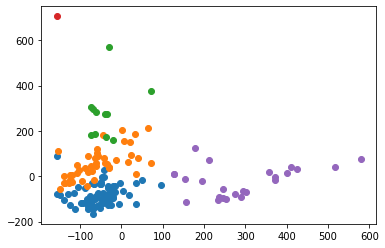

In [ ]:

#filter rows of original data
filtered_label0 = PCA_components[label2 == 0]
filtered_label1 = PCA_components[label2 == 1]
filtered_label2 = PCA_components[label2 == 2]
filtered_label3 = PCA_components[label2 == 3]
filtered_label4 = PCA_components[label2 == 4]
filtered_label5 = PCA_components[label2 == 5]
filtered_label6 = PCA_components[label2 == 6]
filtered_label7 = PCA_components[label2 == 7]
filtered_label8 = PCA_components[label2 == 8]
filtered_label9 = PCA_components[label2 == 9]
#plotting the results of individual clusters meaning. This plot is not representative 
plt.scatter(filtered_label0.iloc[:,0] , filtered_label0.iloc[:,1])
plt.scatter(filtered_label1.iloc[:,0] , filtered_label1.iloc[:,1])
plt.scatter(filtered_label2.iloc[:,0] , filtered_label2.iloc[:,1])
plt.scatter(filtered_label3.iloc[:,0] , filtered_label3.iloc[:,1])
plt.scatter(filtered_label4.iloc[:,0] , filtered_label4.iloc[:,1])
plt.scatter(filtered_label5.iloc[:,0] , filtered_label5.iloc[:,1])
plt.scatter(filtered_label6.iloc[:,0] , filtered_label6.iloc[:,1])
plt.scatter(filtered_label7.iloc[:,0] , filtered_label7.iloc[:,1])
#plt.scatter(filtered_label8.iloc[:,0] , filtered_label8.iloc[:,1])

#plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.show()

In [ ]:
for i in range(0,n):
   print("for the class {} :".format(i) ,CountingForClass(i,label2), "\n")

this is arra 4 0
for the class 0 : {'get': 106, 'like': 81, 'three': 78, 'video': 52, 'waiting': 50, 'right': 48, 'show': 45, 'special': 44, 'try': 39, 'find': 38, 'able': 37, 'dragon': 34, 'great': 31, 'x': 31, 'golden': 30, 'left': 29, 'give': 28, 'see': 28, 'feature': 26, 'time': 26, 'magic': 26, 'roller': 26, 'powerful': 25, 'mute': 24, 'help': 24, 'make': 24, 'silence': 22, 'use': 22, 'number': 21, 'appears': 21, 'different': 21, 'row': 20, 'function': 20, 'world': 20, 'best': 19, 'exciting': 19, 'enter': 17, 'become': 17, 'first': 17, 'let': 17, 'two': 17, 'except': 17, 'luck': 17, 'replaces': 17, 'treasure': 17, 'playing': 16, 'page': 16, 'know': 16, 'paytable': 16, 'fruit': 16, 'amazing': 15, 'volume': 15, 'full': 15, 'choose': 15, 'diamond': 14, 'even': 14, 'coin': 14, 'christmas': 14, 'main': 14, 'card': 14, 'chest': 14, 'remember': 13, 'trophy': 13, 'dare': 13, 'instruction': 13, 'way': 13, 'tiger': 13, 'candy': 13, 'famous': 12, 'wait': 12, 'would': 12, 'god': 12, 'many': 12, 'bomb': 12, 'new': 12, 'lucky': 12, 'rabbit': 12, 'big': 12, 'deluxe': 12, 'simple': 11, 'activate': 11, 'life': 11, 'phoenix': 11, 'fortune': 11, 'bigger': 11, 'award': 11, 'ogre': 11, 'sábado': 11, 'highest': 10, 'cleopatra': 10, 'night': 10, 'power': 10, 'sun': 10, 'light': 10, 'act': 10, 'activated': 10, 'chance': 10, 'turn': 10, 'challenge': 10, 'discover': 10, 'crystal': 10, 'asian': 10, 'central': 10, 'trigger': 10, 'day': 10, 'gold': 10, 'pirate': 10, 'owl': 10, 'longer': 9, 'additional': 9, 'go': 9, 'carnival': 9, 'music': 9, 'queen': 9, 'multiply': 9, 'obtain': 9, 'access': 9, 'well': 9, 'ready': 9, 'think': 9, 'biggest': 9, 'high': 9, 'awaits': 9, 'adventure': 9, 'skill': 9, 'aztec': 9, 'extra': 8, 'double': 8, 'ancient': 8, 'begin': 8, 'burning': 8, 'located': 8, 'one': 8, 'type': 8, 'fill': 8, 'put': 8, 'element': 8, 'mighty': 8, 'version': 8, 'carrot': 8, 'increase': 8, 'claw': 8, 'maximum': 8, 'key': 8, 'gem': 8, 'value': 8, 'randomly': 8, 'broadway': 8, 'ocean': 8, 'sakura': 8, 'spinfinity': 8, 'test': 7, 'story': 7, 'combining': 7, 'start': 7, 'combine': 7, 'grow': 7, 'wealth': 7, 'fat': 7, 'active': 7, 'balance': 7, 'culture': 7, 'come': 7, 'replacing': 7, 'consecutive': 7, 'lead': 7, 'interesting': 7, 'usual': 7, 'next': 7, 'fall': 7, 'part': 7, 'themed': 7, 'expandable': 7, 'never': 7, 'careful': 7, 'mysterious': 7, 'dangerous': 7, 'unlock': 7, 'wheel': 7, 'giovanni': 7, 'miss': 7, 'evil': 7, 'shark': 7, 'stone': 7, 'caesar': 7, 'juego': 7, 'athena': 7, 'rise': 6, 'cherry': 6, 'giving': 6, 'consists': 6, 'farmer': 6, 'need': 6, 'farm': 6, 'background': 6, 'information': 6, 'buy': 6, 'theme': 6, 'selected': 6, 'along': 6, 'every': 6, 'crush': 6, 'possible': 6, 'land': 6, 'based': 6, 'chinese': 6, 'festival': 6, 'offer': 6, 'paylines': 6, 'dancing': 6, 'amp': 6, 'may': 6, 'firework': 6, 'master': 6, 'profit': 6, 'fantasy': 6, 'match': 6, 'loot': 6, 'fire': 6, 'fight': 6, 'battle': 6, 'throw': 6, 'depending': 6, 'magical': 6, 'sweet': 6, 'gemmed': 6, 'casual': 6, 'greek': 6, 'lover': 6, 'colaborador': 6, 'tv': 6, 'dart': 6, 'gangster': 6, 'select': 5, 'star': 5, 'bell': 5, 'favorite': 5, 'mystery': 5, 'surprise': 5, 'legend': 5, 'blood': 5, 'epic': 5, 'single': 5, 'crop': 5, 'super': 5, 'enough': 5, 'elegant': 5, 'carnaval': 5, 'important': 5, 'lower': 5, 'away': 5, 'good': 5, 'hidden': 5, 'back': 5, 'expands': 5, 'people': 5, 'cabaret': 5, 'crazy': 5, 'cell': 5, 'replace': 5, 'dive': 5, 'true': 5, 'credit': 5, 'country': 5, 'travel': 5, 'surely': 5, 'includes': 5, 'favourite': 5, 'ray': 5, 'panda': 5, 'ever': 5, 'kingdom': 5, 'last': 5, 'helpage': 5, 'obtained': 5, 'much': 5, 'graphic': 5, 'previous': 5, 'await': 5, 'opportunity': 5, 'choice': 5, 'russia': 5, 'oyster': 5, 'catch': 5, 'behind': 5, 'robin': 5, 'hood': 5, 'favorito': 5, 'estrella': 5, 'recompensa': 5, 'spy': 5, 'prix': 5, 'bank': 5, 'heist': 5, 'least': 4, 'egypt': 4, 'anubis': 4, 'temple': 4, 'awarded': 4, 'regardless': 4, 'system': 4, 'direction': 4, 'family':